In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import sklearn

The Fantastic 4 team is: 

We will attempt to reproduce some of the results that are shown in the following paper: Reconciling modern machine learning practice
and the bias-variance trade-of[1]. 

Where the concept of double descent is introduced. Which is the idea that the test error can increase as the model complexity increases, but when the number of parameters is large enough, the test error will decrease again.

[1] https://arxiv.org/abs/1805.12114

In [2]:
# Random Fourier Features we can also use poloynomial features in a regression problem (visualize the data)
# Fully connected NN
# Random Forest (decision tree)
# Try some other models (if time permits)

# Importing the data set MNIST

We import the data in two ways, first with a PyTorch implementation and then with a scikit-learn implementation.

### PyTorch implementation

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils import data

import matplotlib.pyplot as plt
import pandas as pd

ModuleNotFoundError: No module named 'torchvision'

In [4]:
training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform= transforms.ToTensor()
    
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform= transforms.ToTensor()
)

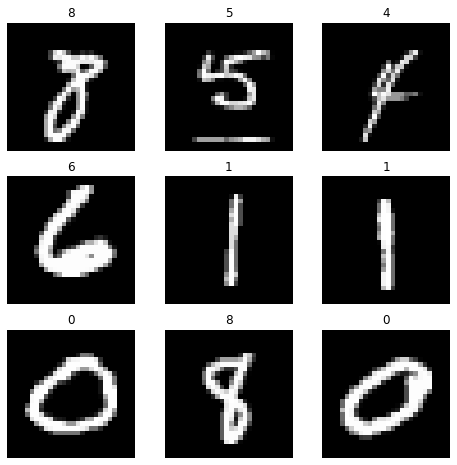

In [5]:
labels_map_minst = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map_minst[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [16]:
training_dataset[0][0].shape

torch.Size([1, 28, 28])

### scikit-learn implementation

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

In [79]:
def get_mnist_data(number_of_samples = 10000, split_percentage = 0.40):
    '''
    Return a subset of the MNIST dataset as numpy arrays 
    :param number_of_samples: the number of datapoints returned
    :param split_percentage: a value that defines the percentage used for testing
    :return: X_train, X_test, y_train, y_test 
    '''
    if (number_of_samples > 100000):
        raise Exception("Number of samples must be smaller than 100.000")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = X[:number_of_samples]
    y = y[:number_of_samples]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percentage, random_state=42)
    
    return X_train, X_test, y_train, y_test

### Attempt 1: Fourier features
##### Made by: Hector Ramirez

In [6]:
# I will start with Random Features as it is also an approximation of the kernel trick

### This is just the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#d = dim of the column vector x
#D is the number of features wanted in the output
def u_vectors(X_test, X_train ,D):
    """_summary_
    Args:
        X (matrix): Data matrix to transform dim (n,d)
        D int: Number of features wanted in the output

    Returns:
        u_test (matrix): matrix of the new features dim (n,D)
        u_train (matrix): matrix of the new features dim (n,D)
    """
    ## the d is the number of columns of X
    d= X_test.shape[1]
    F = np.random.normal(0,1/np.sqrt(d),(D, d))
    # I have to use the same F for the test and the train set to be consistent
    u_test = np.zeros((X_test.shape[0],D))
    u_train = np.zeros((X_train.shape[0],D))
    # Generating the new test set 
    for i in range(X_test.shape[0]):
        u_test[i,:] = (1/np.sqrt(D))*sigmoid(F@X_test[i])
    # Generating the training set 
    for j in range(X_train.shape[0]):
        u_train[j,:] = (1/np.sqrt(D))*sigmoid(F@X_train[j])
    
    return u_test, u_train

In [7]:
def to_random_features(training_set, test_set, D):
    X_train = training_set.data.numpy().reshape(training_set.data.shape[0],-1)
    X_test = test_set.data.numpy().reshape(test_set.data.shape[0],-1)
    y_train = training_set.targets.numpy()
    y_test = test_set.targets.numpy()
    u_test, u_train = u_vectors(X_test, X_train, D)
    #Transform sets to numpy arrays
    #store the labels and the images in two different arrays
    #I can use the same training set for the test set as
    # validation set and let sk learn do the splitting
    
    return u_train, y_train, u_test, y_test

In [8]:
# First I will make sure it works with a small number of features
D = 100
X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    D)

In [9]:
from sklearn.linear_model import LogisticRegression

def train_model(X_test, X_train, y_test, y_train):
    clf = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial')
    clf.fit(X_train, y_train)

    test_error = 1 - clf.score(X_test, y_test)
    train_error = 1 - clf.score(X_train, y_train)
    print("Accuracy on the test set: ", clf.score(X_test, y_test))
    print("Accuracy on the training set: ", clf.score(X_train, y_train))
    
    weights = clf.coef_
    norm = np.linalg.norm(weights, axis=1)
    number_of_features = X_train.shape[1]
    print("number of features: ", number_of_features)
    
    return norm, number_of_features, test_error, train_error





In [18]:
Random_features = np.linspace(1000, 20000, 11, dtype=int)
#Random_features = np.append(Random_features, [30000, 40000, 50000, 60000])
train_loss = []
test_loss = []

Random_features

array([ 1000,  2900,  4800,  6700,  8600, 10500, 12400, 14300, 16200,
       18100, 20000])

In [19]:
RF_df = pd.DataFrame(columns=['Number of features', 'Test error', 'Train error', 'Norm of the weights'])
from tqdm import tqdm

for D in tqdm(Random_features, desc="Random Features"):
    X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    int(D))
    norm, number_of_features, test_error, train_error = train_model(X_test, X_train, y_test, y_train)
    RF_df = RF_df.append(
        {'Number of features': number_of_features,
         'Test error': test_error,
         'Train error': train_error,
         'Norm of the weights': norm},
        ignore_index=True)
    train_loss.append(train_error)
    test_loss.append(test_error)
    
RF_df.to_csv('Random_features.csv')

Random Features:   0%|          | 0/11 [00:00<?, ?it/s]C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:   9%|▉         | 1/11 [00:19<03:10, 19.00s/it]

Accuracy on the test set:  0.9207
Accuracy on the training set:  0.9217
number of features:  1000
Accuracy on the test set:  0.9296
Accuracy on the training set:  0.9304166666666667


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  18%|█▊        | 2/11 [00:56<04:29, 29.93s/it]

number of features:  2900
Accuracy on the test set:  0.9315


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  27%|██▋       | 3/11 [02:04<06:17, 47.23s/it]

Accuracy on the training set:  0.9322666666666667
number of features:  4800
Accuracy on the test set:  0.9308


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  36%|███▋      | 4/11 [03:56<08:30, 72.95s/it]

Accuracy on the training set:  0.9325833333333333
number of features:  6700
Accuracy on the test set:  0.9324


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  45%|████▌     | 5/11 [06:22<09:55, 99.30s/it]

Accuracy on the training set:  0.9330666666666667
number of features:  8600
Accuracy on the test set:  0.9325


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  55%|█████▍    | 6/11 [09:25<10:38, 127.73s/it]

Accuracy on the training set:  0.9336333333333333
number of features:  10500
Accuracy on the test set:  0.9333


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  64%|██████▎   | 7/11 [12:55<10:18, 154.52s/it]

Accuracy on the training set:  0.9339
number of features:  12400
Accuracy on the test set:  0.9317


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  73%|███████▎  | 8/11 [17:08<09:18, 186.02s/it]

Accuracy on the training set:  0.9338833333333333
number of features:  14300
Accuracy on the test set:  0.9326


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  82%|████████▏ | 9/11 [21:59<07:17, 218.87s/it]

Accuracy on the training set:  0.9342166666666667
number of features:  16200


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\1457717485.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy on the test set:  0.9328


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  91%|█████████ | 10/11 [27:12<04:07, 247.78s/it]

Accuracy on the training set:  0.9342833333333334
number of features:  18100
Accuracy on the test set:  0.9333
Accuracy on the training set:  0.9341166666666667
number of features:  20000


C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features: 100%|██████████| 11/11 [33:28<00:00, 182.62s/it]


Text(0.5, 0, 'Number of features')

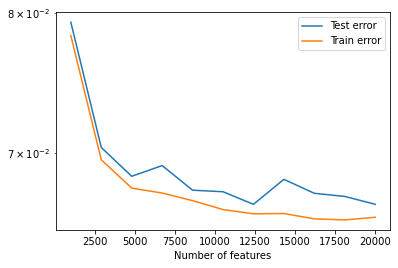

In [22]:
plt.plot(RF_df['Number of features'], RF_df['Test error'], label="Test error")
plt.plot(RF_df['Number of features'], RF_df['Train error'], label="Train error")
#axs[2].plot(RF_df['Number of features'], RF_df['Norm of the weights'], label="Norm of the weights")
plt.legend()
plt.yscale("log")
plt.xlabel("Number of features")
plt.ylabel("Error")


In [23]:
for D in tqdm([30000, 40000, 50000, 60000], desc="Random Features"):
    X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    int(D))
    norm, number_of_features, test_error, train_error = train_model(X_test, X_train, y_test, y_train)
    RF_df = RF_df.append(
        {'Number of features': number_of_features,
         'Test error': test_error,
         'Train error': train_error,
         'Norm of the weights': norm},
        ignore_index=True)
    train_loss.append(train_error)
    test_loss.append(test_error)

Random Features:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\1457717485.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Random Features:   0%|          | 0/4 [15:38<?, ?it/s]


KeyboardInterrupt: 

In [21]:
np.sqrt(-1)

C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\3438155168.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1)


nan

#### Attempt 2: Neural Network

#### Attempt 3: Random Forests

In [81]:
X_train, X_test, y_train, y_test = get_mnist_data(number_of_samples = 10000, split_percentage = 0.40)

In [82]:
print(f"The number of datapoints in train dataset is: {len(X_train)}")
print(f"The number of datapoints in test dataset is: {len(X_test)}")

The number of datapoints in train dataset is: 6000
The number of datapoints in test dataset is: 4000


In [83]:
from sklearn.metrics import zero_one_loss
from sklearn.metrics import mean_squared_error

def sk_zero_one_loss(y_true, y_pred):
    '''
    Returns the percentage of misclassifications
    :param y_true: ground truth (correct) labels
    :param y_pred: predicted labels, as returned by a classifier
    :return: the zero-one classification loss
    '''
    return zero_one_loss(y_true, y_pred)*100

def sk_mean_squared_error(y_true, y_pred):
    '''
    Returns the mean squared error regression loss
    :param y_true: ground truth (correct) labels
    :param y_pred: predicted labels, as returned by a classifier
    :return: the mean squared error regression loss
    '''
    return mean_squared_error(y_true, y_pred)

def one_hot_encode(data, classes=10):
    '''
    Represent categorical variables as binary vectors.
    :param data: an array that we perform the One Hot Encoding on, i.e., we transform each datapoint to a binary vector
    :param classes: number of classes we aim to identify in the dataset
    :return: onehot_encoded, a stack of one-hot vectors
    '''
    onehot_encoded = []
    for value in data:
        vec = np.array([0] * classes)
        vec[int(value)] = 1
        onehot_encoded.append(vec)
        
    return np.stack(onehot_encoded)

In [84]:
from sklearn.ensemble import RandomForestClassifier

def double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100, 
                      X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    '''
    Train a Random Forest Classifier over several different values of the parameters number of trees (N_tree)
    and the maximum number of leaves allowed for each tree (N_max_leaf)
    :param tree_bound: the upper bound for N_tree
    :param leaves_bound: the upper bound for N_max_leaf
    :param tree_step: the step value for N_tree
    :param leaves_step: the step value for N_max_leaf
    :param X_train: the train data 
    :param y_train: the train targets
    :param X_test: the test data
    :param y_test: the test targets
    :return: result_dict
    '''
    
    # we initialize the model with N_tree = 1 and N_max_leaf = 10
    N_max_leaves = 10
    N_tree = 1
    model = RandomForestClassifier(n_estimators=N_tree, 
                                   bootstrap=False, 
                                   criterion='gini', 
                                   max_leaf_nodes=N_max_leaves)
    
    leaf_sizes = []
    trees = []

    # initialize training losses
    zero_one_train_losses = []
    mse_train_losses = []
    
    # initialize testing losses
    zero_one_test_losses = []
    mse_test_losses = []

    while N_max_leaves <= leaves_bound:

        model.fit(X_train, y_train)
        
        # find training loss
        zero_one_train_loss = sk_zero_one_loss(y_train, model.predict(X_train))
        mse_train_loss = sk_mean_squared_error(one_hot_encode(y_train), one_hot_encode(model.predict(X_train)))
        
        # find testing loss
        zero_one_test_loss = sk_zero_one_loss(y_test, model.predict(X_test))   
        mse_test_loss = sk_mean_squared_error(one_hot_encode(y_test), one_hot_encode(model.predict(X_test)))
        
        # add training and testing loss to the training and testing losses arrays
        zero_one_train_losses = np.append(zero_one_train_losses, zero_one_train_loss)
        mse_train_losses = np.append(mse_train_losses, mse_train_loss)
        
        zero_one_test_losses = np.append(zero_one_test_losses, zero_one_test_loss)
        mse_test_losses = np.append(mse_test_losses, mse_test_loss)

        leaf_sizes.append(N_max_leaves)
        trees.append(N_tree)
        
        if (N_max_leaves == 10):
            N_max_leaves = leaves_step
        else:
            N_max_leaves += leaves_step
                
        # define the model for every new value of N_max_leaves  
        model = RandomForestClassifier(n_estimators=N_tree, 
                                       bootstrap=False, 
                                       criterion='gini', 
                                       max_leaf_nodes=N_max_leaves)

    N_max_leaves = N_max_leaves - leaves_step
                
    while N_tree <= tree_bound:
            
        # define the model for every new value of N_tree
        model = RandomForestClassifier(n_estimators=N_tree, 
                                       bootstrap=False, 
                                       criterion='gini', 
                                       max_leaf_nodes=N_max_leaves)
        
        model.fit(X_train, y_train)

        # find training loss
        zero_one_train_loss = sk_zero_one_loss(y_train, model.predict(X_train))
        mse_train_loss = sk_mean_squared_error(one_hot_encode(y_train), one_hot_encode(model.predict(X_train)))
        
        # find testing loss
        zero_one_test_loss = sk_zero_one_loss(y_test, model.predict(X_test))   
        mse_test_loss = sk_mean_squared_error(one_hot_encode(y_test), one_hot_encode(model.predict(X_test)))

        # add training and testing loss to the training and testing losses arrays
        zero_one_train_losses = np.append(zero_one_train_losses, zero_one_train_loss)
        mse_train_losses = np.append(mse_train_losses, mse_train_loss)
        
        zero_one_test_losses = np.append(zero_one_test_losses, zero_one_test_loss)
        mse_test_losses = np.append(mse_test_losses, mse_test_loss)

        leaf_sizes.append(N_max_leaves)
        trees.append(N_tree)
            
        N_tree += tree_step
            
    result_dict = {'zero_one_train_loss': zero_one_train_losses, 
                   'mse_train_loss': mse_train_losses, 
                   'zero_one_test_loss': zero_one_test_losses,
                   'mse_test_loss': mse_test_losses,
                   'leaf_sizes': np.array(leaf_sizes), 
                   'trees': np.array(trees)}    
    
    return result_dict

In [85]:
out = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100, 
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [86]:
import matplotlib.pyplot as plt

def plot_RF(result_dict):
    '''
    Plot the double descent curve for the Random Forest Classifier
    :param result_dict: the returned dictionary from the double_descent_RF function
    '''
    fig, ax = plt.subplots(figsize=(8, 6), sharey = True)

    #define xticks
    tick_location = [0, 10, 20, 30, 40]
    tick_label = ['10 / 1', '1000 / 1', '2000 / 1', '2000 / 10', '2000 / 20']

    plt.subplot(2,1,1)
    plt.title(f'Random Forest double descent curve')
    plt.plot(range(len(result_dict['mse_train_loss'])), result_dict['mse_train_loss'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['mse_test_loss'])), result_dict['mse_test_loss'], 
             color='tab:blue', label = 'Test')
    plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Squared loss')
    plt.xticks(tick_location, [])
    plt.ylim(-0.001, 0.07)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(range(len(result_dict['zero_one_train_loss'])), result_dict['zero_one_train_loss'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['zero_one_test_loss'])), result_dict['zero_one_test_loss'], 
             color='tab:blue', label = 'Test')
    plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Zero-one loss (%)')
    plt.xlabel('Model parameters: $N_{leaf}^{max}$ / $N_{tree}$')
    plt.ylim(-0.001, 35)
    plt.xticks(tick_location, tick_label)

    plt.show()

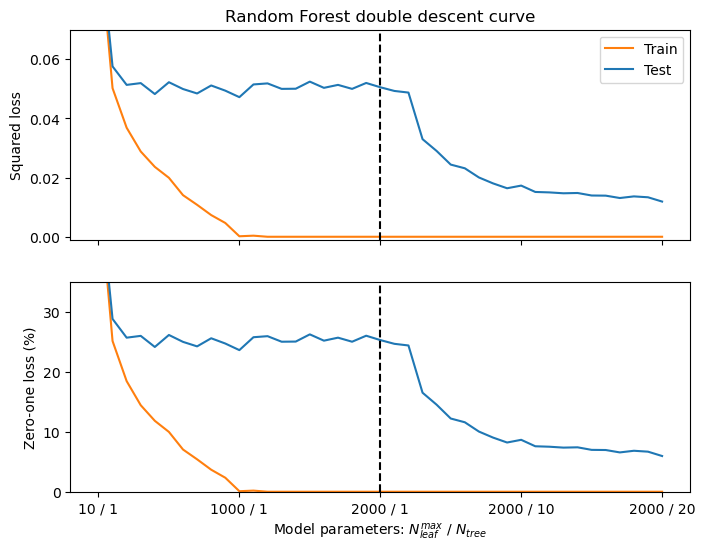

In [87]:
plot_RF(out)